In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy.io.wavfile as wav
from scipy.signal import spectrogram

import os

import cv2

from tqdm import tqdm

import torch
import torch.nn as nn


## image preprocessing

In [2]:
def sauvolaThresholding(intensityNorm, windowSize=15, k=0.5, R=128):
    intensityScaled = (intensityNorm * 255).astype(np.uint8)

    mean = cv2.boxFilter(intensityScaled, ddepth=-1, ksize=(windowSize, windowSize))
    meanSq = cv2.boxFilter(intensityScaled**2, ddepth=-1, ksize=(windowSize, windowSize))
    
    std = np.sqrt(meanSq - mean**2)

    threshold = mean * (1 + k * ((std / R) - 1))

    binarySpectrogram = intensityScaled > threshold

    return binarySpectrogram


def saveBinarySpectrogramAsImage(audioFile, outputPath):
    sampleRate, audioData = wav.read(audioFile)

    # If the audio has multiple channels, use only the first one, this only supports mono audio
    if len(audioData.shape) > 1:
        audioData = audioData[:, 0]

    nps = 2048  # Larger FFT window improves frequency resolution
    frequencies, time, intensity = spectrogram(audioData, 
                                               fs=sampleRate, 
                                               nperseg=nps, 
                                               noverlap=(nps // 2))

    mask = (frequencies >= 10000) & (frequencies <= 40000)
    frequencies = frequencies[mask]
    intensity = intensity[mask, :]  # Apply mask to intensity as well

    # Normalize the intensity
    intensityNorm = np.clip(intensity / np.max(intensity), 0, 1)

    # Apply the threshold AFTER filtering
    binarySpectrogram = sauvolaThresholding(intensityNorm, windowSize=15, k=0.5)

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, frequencies, binarySpectrogram, cmap='gray', shading='gouraud')
    plt.axis('off')  
    plt.tight_layout()
    plt.savefig(outputPath, bbox_inches='tight', pad_inches=0)
    plt.close()  


def processImage(inputImagePath, outputFolder):
    image = cv2.imread(inputImagePath, 0)
    kernel = np.ones((5, 5), np.uint8)

    # Apply median filtering
    medianFilteredImage = cv2.medianBlur(image, 5)

    # Apply dilation
    dilatedImage = cv2.dilate(medianFilteredImage, kernel, iterations=1)

    # Apply erosion
    dilatedThenEroded = cv2.erode(dilatedImage, kernel, iterations=1)

    processedImage = dilatedThenEroded
    baseName = os.path.splitext(os.path.basename(inputImagePath))[0]
    cv2.imwrite(os.path.join(outputFolder, f"{baseName}_processed_img.png"), processedImage)

if __name__ == "__main__":
    # for testing -  testClips  # main folder - LabelledAudioChunks
    audioFolder = "demoClips"  
    # Folder containing audio files 
    binarySpectrogramFolder = "demoBinSpecImgsFolder"  # Folder to save binary spectrogram images   # default = binarySpectrogramImages
    processedImagesFolder = "demoProcessedSpecImgsFolder"  # Folder to save processed images  # default = processedSpectrogramImages

    os.makedirs(binarySpectrogramFolder, exist_ok=True)
    os.makedirs(processedImagesFolder, exist_ok=True)

    audioFiles = [file for file in os.listdir(audioFolder) if file.endswith(".wav")]
    for file in tqdm(audioFiles, desc="Generating Binary Spectrograms"):
        filePath = os.path.join(audioFolder, file)
        outputImagePath = os.path.join(binarySpectrogramFolder, f"{os.path.splitext(file)[0]}_binary.png")

        saveBinarySpectrogramAsImage(filePath, outputImagePath)

    spectrogramFiles = [file for file in os.listdir(binarySpectrogramFolder) if file.endswith(".png")]
    for file in tqdm(spectrogramFiles, desc="Processing Spectrogram Images"):
        inputImagePath = os.path.join(binarySpectrogramFolder, file)

        processImage(inputImagePath, processedImagesFolder)

Processing Spectrogram Images: 100%|██████████| 21/21 [00:00<00:00, 38.61it/s]


## using the model

In [3]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128) 
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten 
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [4]:
# Load the model
model = CNNModel(5) # number of classess
model.load_state_dict(torch.load('cnn_grasshopper_cricket_classifier_26-02-2025.pth'))
model.eval()

C:\Users\Student\AppData\Local\Temp\ipykernel_3460\2630583604.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cnn_grasshopper_cricket_c

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [5]:
classLabels = ['BackgroundNoise', 'MeadowGrasshopper', 'NoID1', 'NoID10', "Roesel'sBush-Cricket"]
# Folder containing test images
imageFolder = "demoProcessedSpecImgsFolder" 

# Loop through each file in the folder
for imageFilename in os.listdir(imageFolder):
    # Check if the file is an image (you can filter by file extension, e.g., .png)
    if imageFilename.endswith(".png"):
        # Full path to the image
        imagePath = os.path.join(imageFolder, imageFilename)
        
        # Load the preprocessed image
        imageData = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
        
        if imageData is None:
            print(f"Error loading image {imagePath}")
            continue  # Skip this image if it couldn't be loaded
        
        # Resize the image to match the input size expected by the model (224x224)
        imageDataResized = cv2.resize(imageData, (224, 224))  # Resize to (224, 224)
        
        # Normalize and prepare the image for the model
        imageTensor = torch.tensor(imageDataResized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, 224, 224)
        imageTensor = imageTensor / 255.0  # Normalize pixel values to [0, 1]
        
        # Perform inference
        with torch.no_grad():
            output = model(imageTensor)  # Pass the image through the model
            _, predicted = torch.max(output, 1)  # Get the index of the class with the highest probability
            classLabel = classLabels[predicted.item()]  # Map the index to the class label
        
        # Print the predicted class for this image
        print(f"Image: {imageFilename}, Predicted Class: {classLabel}")

Image: BackgroundNoise_1_binary_processed_img.png, Predicted Class: BackgroundNoise
Image: BackgroundNoise_2_binary_processed_img.png, Predicted Class: BackgroundNoise
Image: BackgroundNoise_3_binary_processed_img.png, Predicted Class: BackgroundNoise
Image: MeadowGrasshopper_Test1_binary_processed_img.png, Predicted Class: MeadowGrasshopper
Image: MeadowGrasshopper_Test2_binary_processed_img.png, Predicted Class: MeadowGrasshopper
Image: MeadowGrasshopper_Test3_binary_processed_img.png, Predicted Class: MeadowGrasshopper
Image: MeadowGrasshopper_Test4_binary_processed_img.png, Predicted Class: MeadowGrasshopper
Image: MeadowGrasshopper_Test5_binary_processed_img.png, Predicted Class: MeadowGrasshopper
Image: NoID10_1_binary_processed_img.png, Predicted Class: NoID10
Image: NoID10_2_binary_processed_img.png, Predicted Class: NoID10
Image: NoID10_3_binary_processed_img.png, Predicted Class: NoID10
Image: NoID10_4_binary_processed_img.png, Predicted Class: NoID10
Image: NoID10_5_binary_p

## tSNE on data

Applying t-SNE...


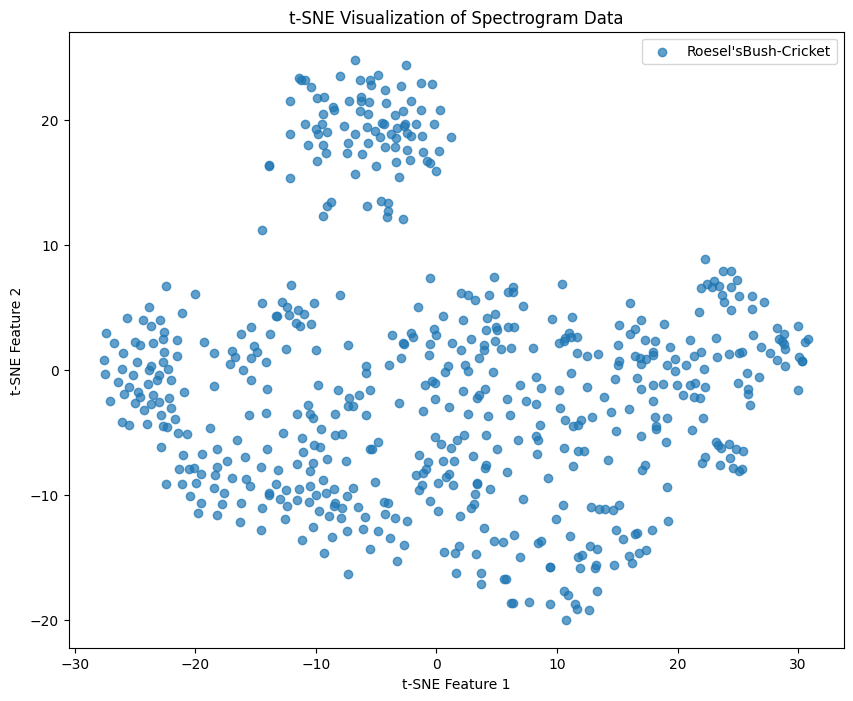

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

imageFolder = "testProcessedSpecImgsFolder"

classLabels = ['BackgroundNoise', 'MeadowGrasshopper', 'NoID1', 'NoID10', "Roesel'sBush-Cricket"]
label_to_index = {label: idx for idx, label in enumerate(classLabels)}

image_data = []
image_labels = []

for imageFilename in tqdm(os.listdir(imageFolder), desc="Collecting image data"):
    if imageFilename.endswith(".png"):
        imagePath = os.path.join(imageFolder, imageFilename)
        image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Error loading image {imagePath}")
            continue

        image_resized = cv2.resize(image, (224, 224))
        image_data.append(image_resized.flatten())

        image_tensor = torch.tensor(image_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        image_tensor = image_tensor / 255.0

        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            image_labels.append(predicted.item())

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
image_data_2d = tsne.fit_transform(image_data)

plt.figure(figsize=(10, 8))
for label in np.unique(image_labels):
    indices = image_labels == label
    plt.scatter(image_data_2d[indices, 0], image_data_2d[indices, 1], label=classLabels[label], alpha=0.7)

plt.title('t-SNE Visualization of Spectrogram Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()
